# **Загрузка библиотек**

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import nbformat
import plotly.graph_objects as go
import cmath 

from scipy.stats import normaltest, levene, norm
from scipy.optimize import curve_fit
from scipy.stats import f_oneway
from scipy.fft import fft, fftfreq, rfft, rfftfreq, irfft, ifft

sns.set_theme()
sns.set_palette("deep")

# **Acceleration in Booster measured with Fbooster_perimeterT**

## Booster parameters

In [9]:
mass_proton = 938.256 * 10**6 # масса покоя протона 
mass_proton_kg = 1.67252 * 10**(-24) # тоже самое только в кг (но нужно проверить)

mass_neutron = 938.2 * 10**6 # масса покоя нейрона 

mass_electron = 0.5111006 * 10**6 # масса покоя электрона 
charge_electron  = 1.6021 * 10**(-19) # заряд электрона в Кл 
e_conv = 299.7925 # ПОСМОТРЕТЬ (коэф перевода )
mass_electron_kg = 9.109383 * 10**(-28) # масса электрона кг
charge_electron_sgs = 4.80298 * 10*(-10) # заряд электрона СГС 


charge_number = 28 # зарядовое число 
mass_number = 124 # массовое число
booster_perimeter = 21096 # периметр бустера в мм


radius_proton  = (e_conv * charge_electron_sgs) / mass_proton # радиус протона 
radius_electron = (charge_electron_sgs * e_conv) / mass_electron # радиус электрона

k_b = 1.38054 * 10**(-16) # ----
Z_n = 377 # --- 
c = 2.997925 * 10**10

## Data reading

In [10]:
offset = 2 * 3.4 * 10e6
delta_time  = 2 * 10**(-8)
window = 20

zeros_padding = np.zeros((2,3))

In [11]:
booster_acceleration_file_1_1 = r'BoosterAcceleration1_1half.dat'
booster_acceleration_file_1_2 = r'BoosterAcceleration1_2half.dat'
booster_acceleration_file_2_1 = r'BoosterAcceleration2_1half.dat'
booster_acceleration_file_2_2 = r'BoosterAcceleration2_2half.dat'

In [12]:
with open(booster_acceleration_file_1_1, "rb") as file:
    M_1_1 = np.load(file).reshape(-1,3)

with open(booster_acceleration_file_1_2, "rb") as file:
    M_1_2 = np.load(file).reshape(-1,3)

with open(booster_acceleration_file_2_1, "rb") as file:
    M_2_1 = np.load(file).reshape(-1,3)

with open(booster_acceleration_file_2_2, "rb") as file:
    M_2_2 = np.load(file).reshape(-1,3)

In [13]:
booster_acceleration_data = [[M_1_1, M_1_2], [M_2_1, M_2_2]]

In [14]:
data_length_1_1 = np.arange(booster_acceleration_data[0][0].shape[0] / window).astype(int)
data_length_1_2 = np.arange(booster_acceleration_data[0][1].shape[0] / window - 1).astype(int)

data_length_2_1 = np.arange(booster_acceleration_data[1][0].shape[0] / window - 1).astype(int)
data_length_2_2 = np.arange(booster_acceleration_data[1][1].shape[0] / window - 1).astype(int)

In [15]:
booster_acceleration_data[0][0] = np.vstack((zeros_padding, booster_acceleration_data[0][0]))
booster_acceleration_data[0][1] = np.vstack((zeros_padding, booster_acceleration_data[0][1]))

booster_acceleration_data[1][0] = np.vstack((zeros_padding, booster_acceleration_data[1][0]))
booster_acceleration_data[1][1] = np.vstack((zeros_padding, booster_acceleration_data[1][1]))

In [16]:
real_time_data_1_1 = delta_time * booster_acceleration_data[0][0][window * data_length_1_1, 0] # реальное время, а не фиктивное 
real_time_data_1_2 = delta_time * (booster_acceleration_data[0][1][window * data_length_1_2, 0] + offset / 2)

real_time_data_2_1 = delta_time * booster_acceleration_data[1][0][window * data_length_2_1, 0]
real_time_data_2_2 = delta_time * (booster_acceleration_data[1][1][window * data_length_2_2, 0] + offset / 2)

In [17]:
average_amplitude_data_1_1 = 1 / window * np.array([np.sum(booster_acceleration_data[0][0][window*i:window*i + window, 1]) for i in data_length_1_1]) # усреднение амплитуд 
average_amplitude_data_1_2 = 1 / window * np.array([np.sum(booster_acceleration_data[0][1][window*i:window*i + window, 1]) for i in data_length_1_2])

average_amplitude_data_2_1 = 1 / window * np.array([np.sum(booster_acceleration_data[1][0][window*i:window*i + window, 1]) for i in data_length_2_1])
average_amplitude_data_2_2 = 1 / window * np.array([np.sum(booster_acceleration_data[1][1][window*i:window*i + window, 1]) for i in data_length_2_2])

In [18]:
average_phase_data_1_1 = 1 / window * np.array([np.sum(booster_acceleration_data[0][0][window*i:window*i + window, 2]) for i in data_length_1_1]) # усреднение фаз 
average_phase_data_1_2 = 1 / window * np.array([np.sum(booster_acceleration_data[0][1][window*i:window*i + window, 2]) for i in data_length_1_2])

average_phase_data_2_1 = 1 / window * np.array([np.sum(booster_acceleration_data[1][0][window*i:window*i + window, 2]) for i in data_length_2_1])
average_phase_data_2_2 = 1 / window * np.array([np.sum(booster_acceleration_data[1][1][window*i:window*i + window, 2]) for i in data_length_2_2])

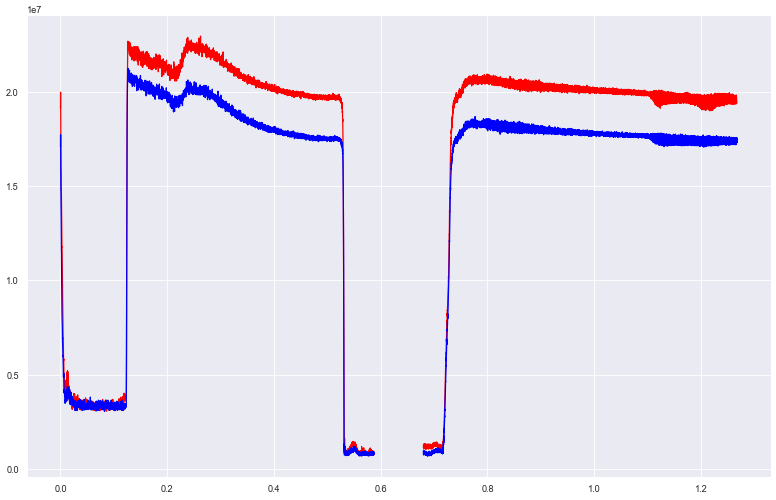

In [19]:
fig = plt.figure(figsize=(16, 10), dpi=60, facecolor="w", edgecolor="k")

plt.plot(real_time_data_1_1, average_amplitude_data_1_1, color='red')
plt.plot(real_time_data_1_2, average_amplitude_data_1_2, color='red')
plt.plot(real_time_data_2_1, average_amplitude_data_2_1, color='blue')
plt.plot(real_time_data_2_2, average_amplitude_data_2_2, color='blue')

None

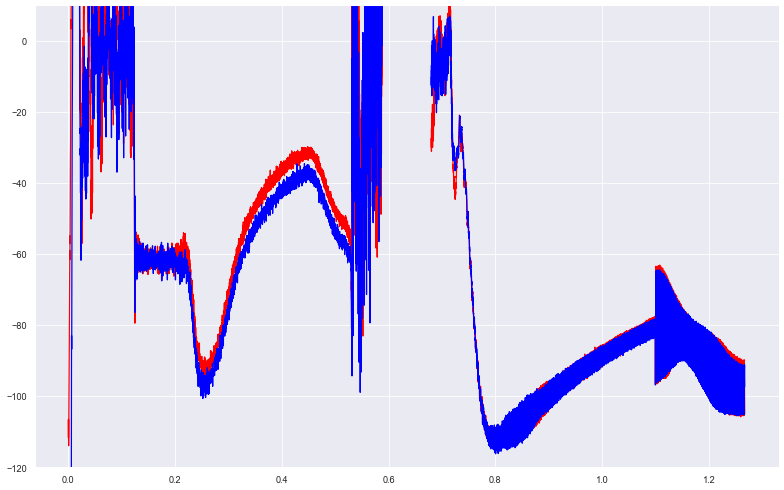

In [20]:
fig = plt.figure(figsize=(16, 10), dpi=60, facecolor="w", edgecolor="k")

plt.plot(real_time_data_1_1, average_phase_data_1_1, color='red')
plt.plot(real_time_data_1_2, average_phase_data_1_2, color='red')
plt.plot(real_time_data_2_1, average_phase_data_2_1, color='blue')
plt.plot(real_time_data_2_2, average_phase_data_2_2, color='blue')

plt.ylim([-120, 10])

None

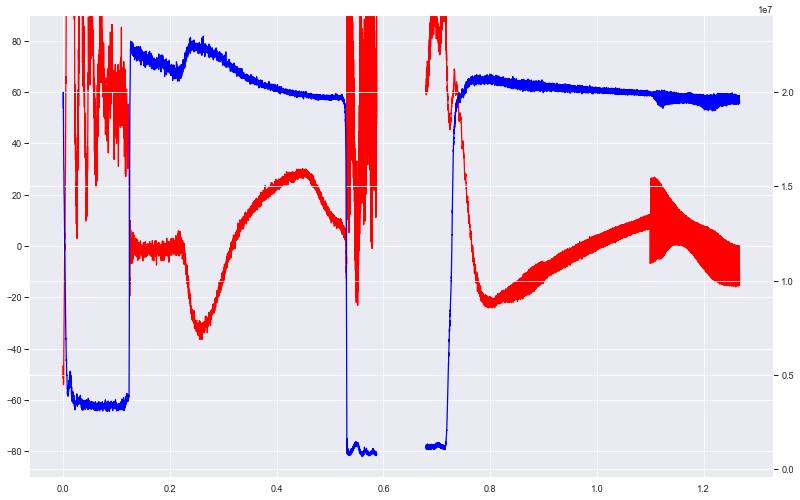

In [21]:
fig = plt.figure(figsize=(16, 10), dpi=60, facecolor="w", edgecolor="k")

plt.plot(real_time_data_1_1, average_phase_data_1_1 + 60, color='red')
plt.plot(real_time_data_1_2, average_phase_data_1_2 + 90, color='red')

plt.ylim([-90, 90])

plt.twinx()
plt.plot(real_time_data_1_1, average_amplitude_data_1_1, color='blue')
plt.plot(real_time_data_2_2, average_amplitude_data_1_2, color='blue')


None

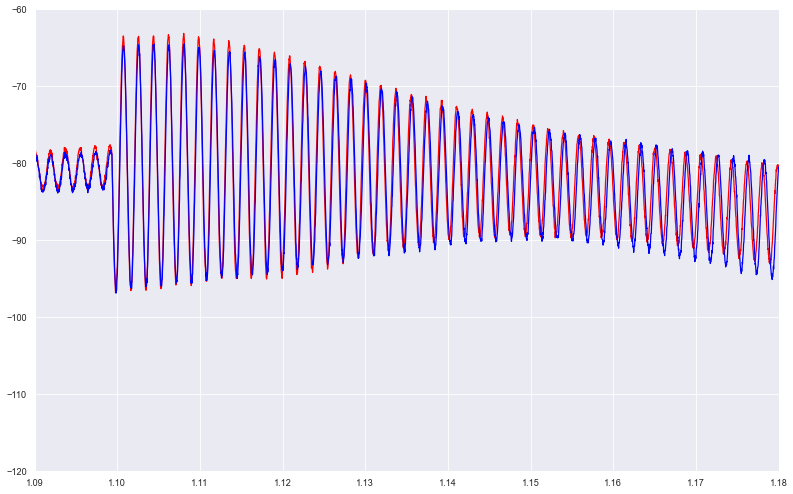

In [22]:
fig = plt.figure(figsize=(16, 10), dpi=60, facecolor="w", edgecolor="k")

plt.plot(real_time_data_1_1, average_phase_data_1_1, color='red')
plt.plot(real_time_data_1_2, average_phase_data_1_2, color='red')
plt.plot(real_time_data_2_1, average_phase_data_2_1, color='blue')
plt.plot(real_time_data_2_2, average_phase_data_2_2, color='blue')

plt.ylim([-120, -60])
plt.xlim([1.09, 1.18])

None

# лучше сделать два отдельных графика: 1-й участок ускорения 2-второй участок ускорения 

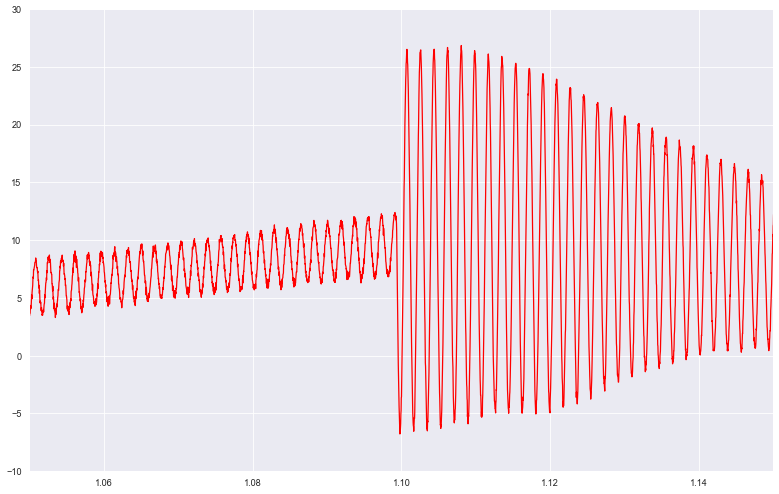

In [23]:
fig = plt.figure(figsize=(16, 10), dpi=60, facecolor="w", edgecolor="k")

plt.plot(real_time_data_1_1, average_phase_data_1_1 + 90, color='red')
plt.plot(real_time_data_1_2, average_phase_data_1_2 + 90, color='red')

plt.ylim([-10, 30])
plt.xlim([1.05, 1.15])

None

# Booster parameters

In [24]:
mass_neutron =  930.712 * 10**6

In [25]:
new_data_length_1_1 = np.arange(1, booster_acceleration_data[0][0].shape[0] / window - 2).astype(int)
new_data_length_1_2 = np.arange(1, booster_acceleration_data[0][1].shape[0] / window - 2).astype(int)

new_data_length_2_1 = np.arange(1, booster_acceleration_data[1][0].shape[0] / window - 2).astype(int)
new_data_length_2_2 = np.arange(1, booster_acceleration_data[1][1].shape[0] / window - 2).astype(int)

In [26]:
beta_1_1 = window * booster_perimeter / (c * (real_time_data_1_1[new_data_length_1_1+1] - real_time_data_1_1[new_data_length_1_1]))
beta_1_2 = window * booster_perimeter / (c * (real_time_data_1_2[new_data_length_1_2+1] - real_time_data_1_2[new_data_length_1_2]))

beta_2_1 = window * booster_perimeter / (c * (real_time_data_2_1[new_data_length_2_1+1] - real_time_data_2_1[new_data_length_2_1]))
beta_2_2 = window * booster_perimeter / (c * (real_time_data_2_2[new_data_length_2_2+1] - real_time_data_2_2[new_data_length_2_2]))

In [27]:
gamma_1_1 = 1 / np.sqrt(1 - beta_1_1**2) # Лоренс фактор 
gamma_1_2 = 1 / np.sqrt(1 - beta_1_2**2)

gamma_2_1 = 1 / np.sqrt(1 - beta_2_1**2)
gamma_2_2 = 1 / np.sqrt(1 - beta_2_2**2)

In [28]:
total_energy_1_1 = (gamma_1_1 - 1) * mass_neutron # Полная энергия 
total_energy_1_2 = (gamma_1_2 - 1) * mass_neutron

total_energy_2_1 = (gamma_2_1 - 1) * mass_neutron
total_energy_2_2 = (gamma_2_2 - 1) * mass_neutron

In [29]:
pulse_1_1 = beta_1_1 * gamma_1_1 * mass_neutron # Импульс
pulse_1_2 = beta_1_2 * gamma_1_2 * mass_neutron

pulse_2_1 = beta_2_1 * gamma_2_1 * mass_neutron
pulse_2_2 = beta_2_2 * gamma_2_2 * mass_neutron

In [30]:
new_real_time_data_1_1 = delta_time * booster_acceleration_data[0][0][window * new_data_length_1_1, 0]
new_real_time_data_2_1 = delta_time * booster_acceleration_data[1][0][window * new_data_length_2_1, 0]

new_real_time_data_1_2 = delta_time * (booster_acceleration_data[0][1][window * new_data_length_1_2, 0] + offset / 2)
new_real_time_data_2_2 = delta_time * (booster_acceleration_data[1][1][window * new_data_length_2_2, 0] + offset / 2)

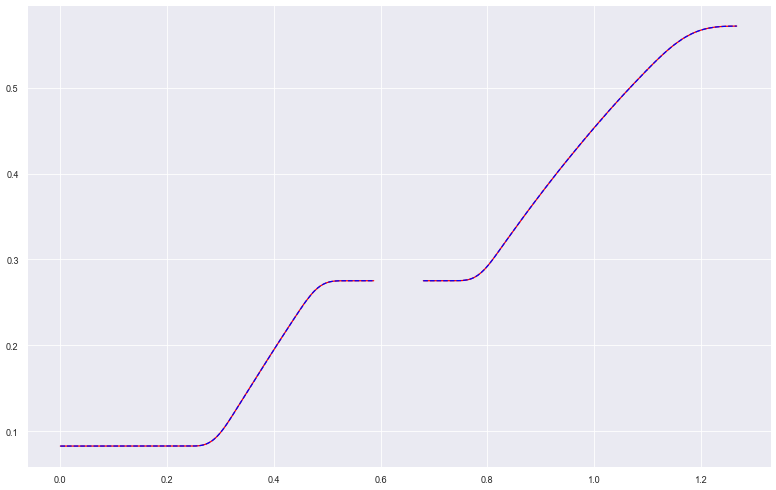

In [31]:
fig = plt.figure(figsize=(16, 10), dpi=60, facecolor="w", edgecolor="k")

plt.plot(new_real_time_data_1_1, beta_1_1, color='red')
plt.plot(new_real_time_data_1_2, beta_1_2, color='red')
plt.plot(new_real_time_data_2_1, beta_2_1, color='blue', ls='--')
plt.plot(new_real_time_data_2_2, beta_2_2, color='blue', ls='--')

None

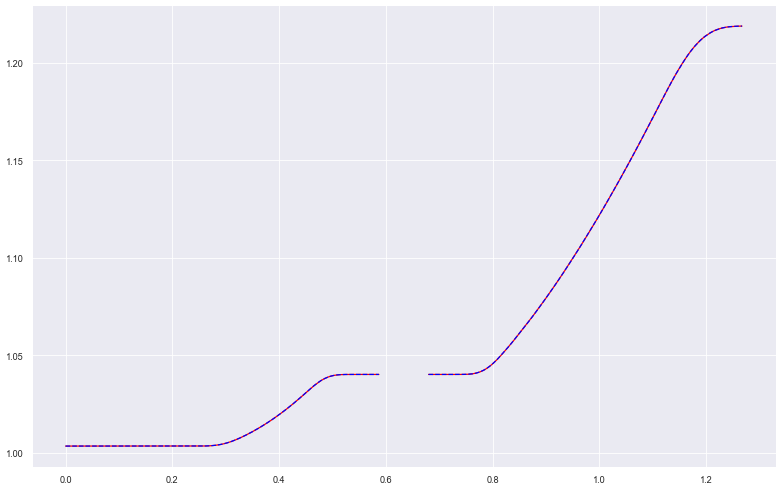

In [32]:
fig = plt.figure(figsize=(16, 10), dpi=60, facecolor="w", edgecolor="k")

plt.plot(new_real_time_data_1_1, gamma_1_1, color='red')
plt.plot(new_real_time_data_1_2, gamma_1_2, color='red')
plt.plot(new_real_time_data_2_1, gamma_2_1, color='blue', ls='--')
plt.plot(new_real_time_data_2_2, gamma_2_2, color='blue', ls='--')

None

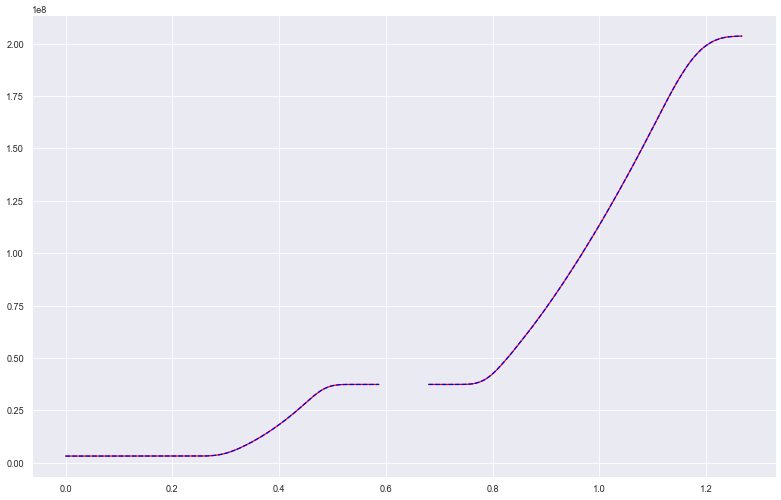

In [33]:
fig = plt.figure(figsize=(16, 10), dpi=60, facecolor="w", edgecolor="k")

plt.plot(new_real_time_data_1_1, total_energy_1_1, color='red')
plt.plot(new_real_time_data_1_2, total_energy_1_2, color='red')
plt.plot(new_real_time_data_2_1, total_energy_2_1, color='blue', ls='--')
plt.plot(new_real_time_data_2_2, total_energy_2_2, color='blue', ls='--')

None

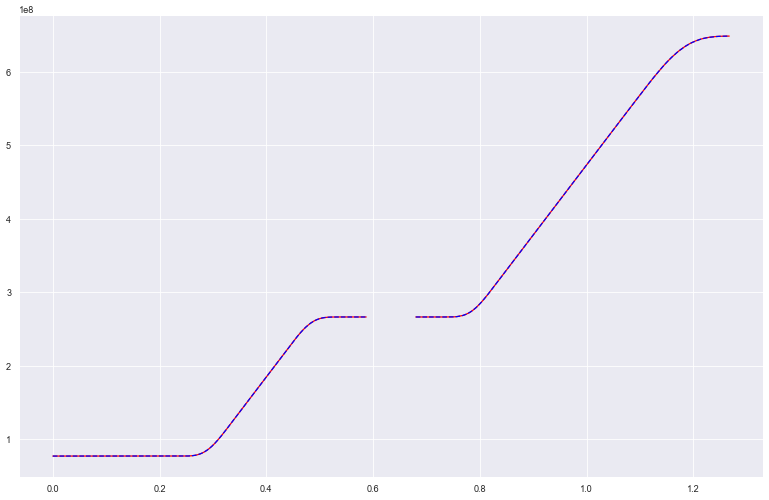

In [34]:
fig = plt.figure(figsize=(16, 10), dpi=60, facecolor="w", edgecolor="k")

plt.plot(new_real_time_data_1_1, pulse_1_1, color='red')
plt.plot(new_real_time_data_1_2, pulse_1_2, color='red')
plt.plot(new_real_time_data_2_1, pulse_2_1, color='blue', ls='--')
plt.plot(new_real_time_data_2_2, pulse_2_2, color='blue', ls='--')

None

In [35]:
LEFT_BOARD_INJECTION_FREQENCY = 1.175 * 10**5
RIGHT_BOARD_INJECTION_FREQENCY = 1.178 * 10**5

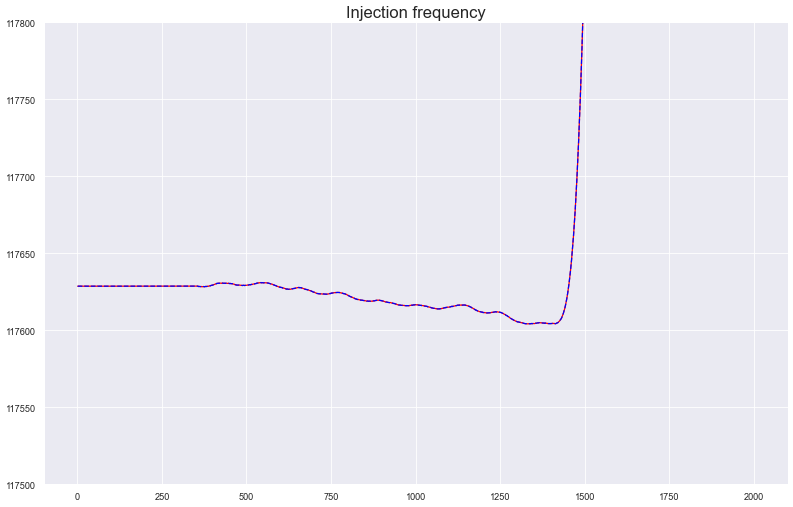

In [36]:
fig = plt.figure(figsize=(16, 10), dpi=60, facecolor="w", edgecolor="k")

plt.plot(new_data_length_1_1[:2001], window * (real_time_data_1_1[new_data_length_1_1+1] - real_time_data_1_1[new_data_length_1_1])[:2001]**(-1), color='red')
plt.plot(new_data_length_1_2[:2001], window * (real_time_data_1_1[(new_data_length_1_2+1)[:2001]] - real_time_data_1_1[new_data_length_1_2[:2001]])**(-1), color='blue', ls='--')

plt.ylim([LEFT_BOARD_INJECTION_FREQENCY, RIGHT_BOARD_INJECTION_FREQENCY]) # лучше задать как константы 

plt.title('Injection frequency', fontsize=20)

None

построить график файла magnetic_data в секундах 

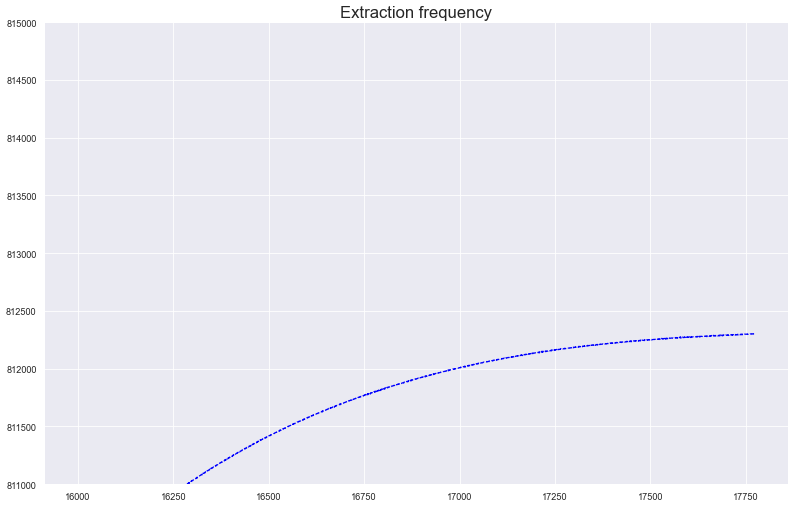

In [37]:
fig = plt.figure(figsize=(16, 10), dpi=60, facecolor="w", edgecolor="k")

plt.plot(new_data_length_2_1[16000:], window * (real_time_data_2_1[new_data_length_2_1+1] - real_time_data_1_1[21_11])[16000:]**(-1), color='red')
plt.plot(new_data_length_2_2[16000:], window * (real_time_data_2_2[(new_data_length_2_2+1)[16000:]] - real_time_data_2_2[new_data_length_2_2[16000:]])**(-1), color='blue', ls='--')

plt.ylim([8.11 * 10**5, 8.15 * 10**5])

plt.title('Extraction frequency', fontsize=20)


None

# аналогично сделать для энергии вывода 

## Reading Dbooster_perimeterbooster_perimeterT and comparing it to Fbooster_perimeterT 

In [38]:
booster_NPCT_file = r'E:\Project python\START_JINR\jinr_practice_3\booster_data\27_01_23_booster_NPCT_2.bin'

In [39]:
booster_NPCT_data = np.fromfile(booster_NPCT_file, dtype='double')

FileNotFoundError: [Errno 2] No such file or directory: 'E:\\Project python\\START_JINR\\jinr_practice_3\\booster_data\\27_01_23_booster_NPCT_2.bin'

In [ ]:
window = 5
delta_time = 1e-3
time_offset = 0.31

booster_NPCT_length = np.arange(window, len(booster_NPCT_data) - window)

In [ ]:
smoothed_signal_booster_NPCT = 1 / (500 * (2 * window + 1)) * np.array([np.sum(booster_NPCT_data[i-window:i+window+1]) for i in booster_NPCT_length]) # сглаживание усреднением 

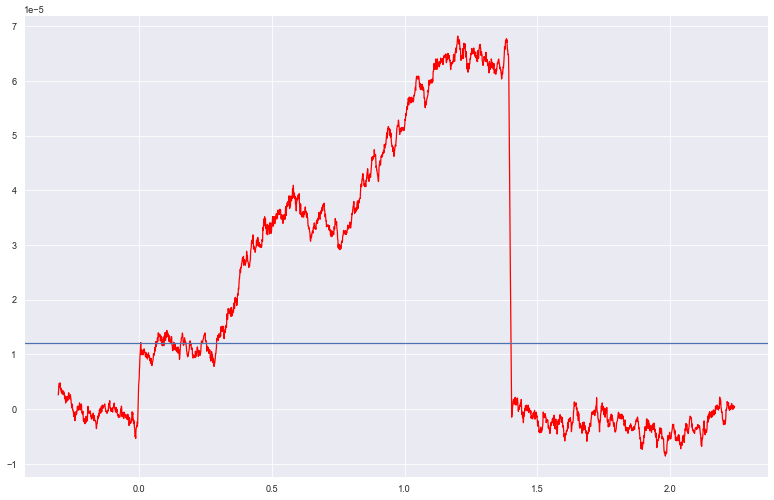

In [ ]:
fig = plt.figure(figsize=(16, 10), dpi=60, facecolor="w", edgecolor="k")

plt.plot(delta_time * booster_NPCT_length-time_offset, smoothed_signal_booster_NPCT, color='red')

plt.axhline(y=12*10**(-6)) # выбирается на глаз, какая интенсивность инжекции 


None

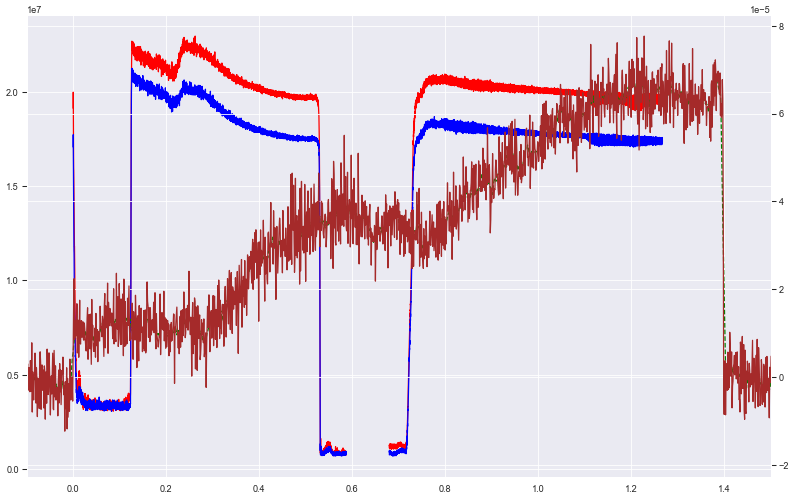

In [ ]:
fig = plt.figure(figsize=(16, 10), dpi=60, facecolor="w", edgecolor="k")

plt.plot(real_time_data_1_1, average_amplitude_data_1_1, color='red')
plt.plot(real_time_data_1_2, average_amplitude_data_1_2, color='red')
plt.plot(real_time_data_2_1, average_amplitude_data_2_1, color='blue')
plt.plot(real_time_data_2_2, average_amplitude_data_2_2, color='blue')

plt.twinx()
plt.plot(delta_time*booster_NPCT_length-time_offset, smoothed_signal_booster_NPCT, color='green', ls='--')
plt.plot(delta_time*booster_NPCT_length-time_offset, booster_NPCT_data[booster_NPCT_length] / 500, color='brown')

plt.xlim([-.1, 1.5])

None

In [ ]:
booster_field_file = r'E:\Project python\START_JINR\jinr_practice_3\booster_data\27_01_23_booster_field_2.bin'

In [ ]:
magnetic_data = np.fromfile(booster_field_file, dtype='double') # данные магнитного поля 

In [ ]:
INJECTION_FIELD = 221.03

In [ ]:
average_radius_curvature_orbit = 1.006 * INJECTION_FIELD / (2 * np.pi) * (360 / 9)
# (221.03 - поле инжекции в гауссах)

## средний радиус кривизны орбиты 

In [ ]:
pulse = charge_number / mass_number * 10e3 * e_conv * magnetic_data[booster_NPCT_length] * average_radius_curvature_orbit # импульс, вычесленный из магнитной жескости пучка на каждом отсчете 

In [ ]:
beta = pulse / (np.sqrt(pulse**2 + mass_neutron**2)) # Лоренс фактор 

In [ ]:
period = booster_perimeter / (beta * c) # период обращения 

In [ ]:
beam_intensity = smoothed_signal_booster_NPCT / (charge_electron  * charge_number) * (booster_perimeter / (beta * c)) # интенсивность пучка в частицах 

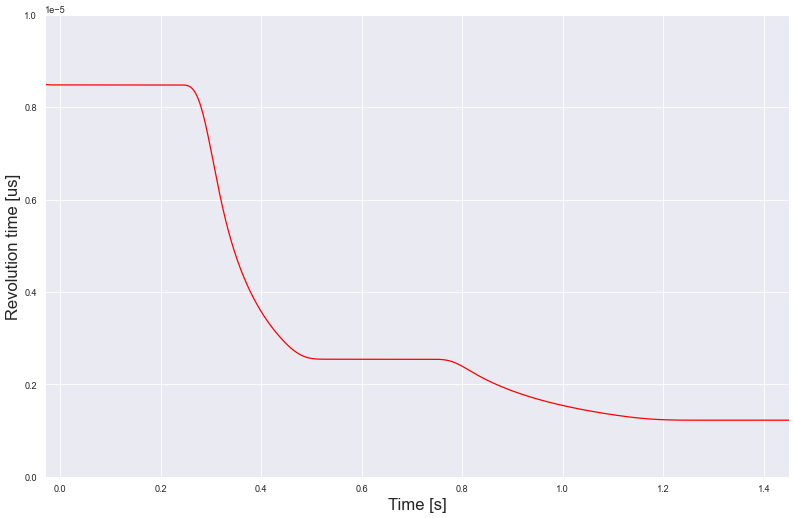

In [ ]:
fig = plt.figure(figsize=(16, 10), dpi=60, facecolor="w", edgecolor="k")

plt.plot(delta_time * booster_NPCT_length - time_offset, period, color='red')

plt.xlim([-.03, 1.45])
plt.ylim([0, 1*10**(-5)])

plt.xlabel('Time [s]', fontsize=20)
plt.ylabel('Revolution time [us]', fontsize=20)

None

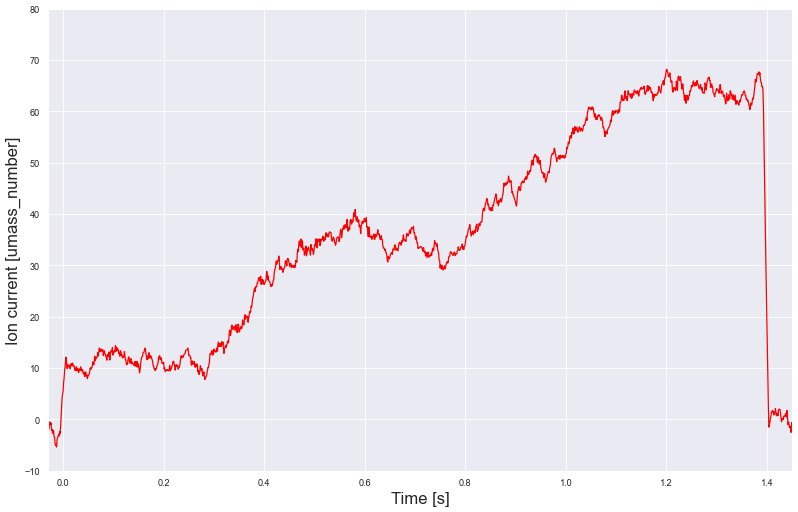

In [ ]:
fig = plt.figure(figsize=(16, 10), dpi=60, facecolor="w", edgecolor="k")

plt.plot(delta_time * booster_NPCT_length - time_offset, smoothed_signal_booster_NPCT * 10e5, color='red') # пересчет через коэф перччета датчика 10e5

plt.xlim([-.03, 1.45])
plt.ylim([-10, 80])

plt.xlabel('Time [s]', fontsize=20)
plt.ylabel('Ion current [umass_number]', fontsize=20)

None

# этот график без учета ускорения 

In [ ]:
average_amplitude_data_2_1

array([17080699.2745099 , 17734519.67918481, 16641677.27659644, ...,
         784971.92215437,   848040.0792641 ,   785596.02060757])

In [ ]:
average_amplitude_data_2_1[new_data_length_2_1]

array([17734519.67918481, 16641677.27659644, 15653473.41504385, ...,
         819658.34677151,   784971.92215437,   848040.0792641 ])

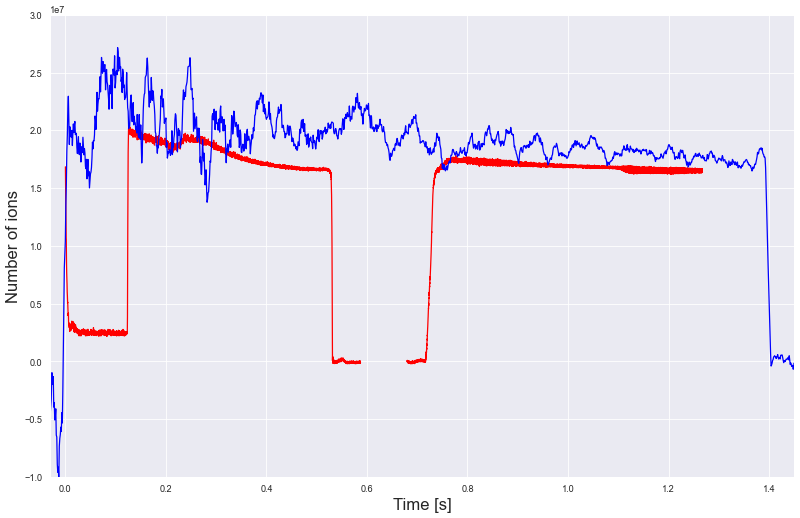

In [ ]:
fig = plt.figure(figsize=(16, 10), dpi=60, facecolor="w", edgecolor="k")

plt.plot(new_real_time_data_2_1, average_amplitude_data_2_1[new_data_length_2_1] - 0.9*10**6, color='red')
plt.plot(new_real_time_data_2_2, average_amplitude_data_2_2[new_data_length_2_2] - 0.9*10**6, color='red')
plt.plot(delta_time * booster_NPCT_length - time_offset, beam_intensity, color='blue')


plt.xlim([-.03, 1.45])
plt.ylim([-1*10**7, 3*10**7])

plt.xlabel('Time [s]', fontsize=20)
plt.ylabel('Number of ions', fontsize=20)

None

# данные интенсивности с быстрого и параметрического трасформаторов 